In [1]:
import os
# to use or not to use GPU
#os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

# packages for model graph visualization
#!pip install -q pydot
# install graphviz https://graphviz.gitlab.io/download/ 

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub
!pip install -q -U tensorflow-text
import tensorflow_text as text
!pip install -q tf-models-official
from official.nlp import optimization  # to create AdamW optimizer

import json
import re
import random
import numpy as np
import matplotlib.pyplot as plt

#save_path = "/content/drive/My Drive/Colab Notebooks/"

     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 1.8 MB 5.6 MB/s 
     |████████████████████████████████| 596 kB 36.5 MB/s 
     |████████████████████████████████| 1.1 MB 39.3 MB/s 
     |████████████████████████████████| 90 kB 8.7 MB/s 
     |████████████████████████████████| 47.7 MB 1.6 MB/s 
     |████████████████████████████████| 213 kB 49.0 MB/s 
     |████████████████████████████████| 99 kB 8.9 MB/s 
     |████████████████████████████████| 1.2 MB 43.5 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 352 kB 48.9 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
save_path = "/content/drive/My Drive/Colab Notebooks/"

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
# checking if we have access to a GPU

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
#@title Data Loading & Preprocessing


In [7]:
with open(save_path+'kafka_data_preprocessed_high_occurrence_50.json') as f:
    data = json.load(f)
    # shuffle data
    random.shuffle(data)
    # create description and assignee list
    desc_data = []
    assignee_data = []
    for item in data:
        desc_data.append(item['description'])
        assignee_data.append(item['assignee'])

In [8]:
print('sample assignees:', assignee_data[0:2])
print('sample descriptions:', desc_data[0:2])

sample assignees: ['Manikumar', 'A. Sophie Blee-Goldman']
sample descriptions: ['Minor InputStream leakage during the server initialization in AppInfo.scala. Patch attached.', 'The current implementation of InMemoryWindowStore copies all record data into a new list and returns an iterator over that list when fetching. That is inefficient in terms of both memory and time. The fetching logic should be moved to the iterators, which could be cleaned up as well (currently they rely on ListIterator to provide peekNextKey() functionality, which is unnecessary).']


In [9]:
# transform description data to tensorflow dataset
descriptions = tf.data.Dataset.from_tensor_slices(desc_data)
for input in descriptions.take(2):
    print(input)

tf.Tensor(b'Minor InputStream leakage during the server initialization in AppInfo.scala. Patch attached.', shape=(), dtype=string)
tf.Tensor(b'The current implementation of InMemoryWindowStore copies all record data into a new list and returns an iterator over that list when fetching. That is inefficient in terms of both memory and time. The fetching logic should be moved to the iterators, which could be cleaned up as well (currently they rely on ListIterator to provide peekNextKey() functionality, which is unnecessary).', shape=(), dtype=string)


In [10]:
# target vectorize assignee data
assignee_dict = {assignee: i for i, assignee in enumerate(list(set(assignee_data)))}
assignee_dict



{'A. Sophie Blee-Goldman': 19,
 'Apurva Mehta': 26,
 'Ashish Singh': 13,
 'Bill Bejeck': 9,
 'Boyang Chen': 17,
 'Bruno Cadonna': 16,
 'Chia-Ping Tsai': 11,
 'Chris Egerton': 34,
 'Colin McCabe': 28,
 'Damian Guy': 4,
 'David Jacot': 8,
 'Dong Lin': 14,
 'Dongjin Lee': 12,
 'Eno Thereska': 32,
 'Ewen Cheslack-Postava': 21,
 'Grant Henke': 5,
 'Guozhang Wang': 0,
 'Gwen Shapira': 35,
 'Harsha': 29,
 'Ismael Juma': 24,
 'Jason Gustafson': 30,
 'Jay Kreps': 31,
 'Jiangjie Qin': 7,
 'John Roesler': 15,
 'Jun Rao': 6,
 'Konstantine Karantasis': 1,
 'Luke Chen': 20,
 'Manikumar': 33,
 'Matthias J. Sax': 18,
 'Neha Narkhede': 27,
 'Rajini Sivaram': 23,
 'Randall Hauch': 2,
 'Swapnil Ghike': 10,
 'Tom Bentley': 22,
 'Vahid Hashemian': 3,
 'huxihx': 25}

In [11]:
# create target vector
assignee_vector = [assignee_dict[assignee] for assignee in assignee_data]
assignee_vector[:10]

[33, 19, 21, 2, 27, 4, 28, 5, 4, 17]

In [12]:
# assignee target vector to one hot vector
assignee_tensor = tf.data.Dataset.from_tensor_slices(assignee_vector)
assignee_one_hot = assignee_tensor.map(lambda x: tf.one_hot(x, len(assignee_dict)))
for assignee in assignee_one_hot.take(5):
    print(assignee)

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)


In [13]:
# zip descriptions and assignee for training
dataset = tf.data.Dataset.zip((descriptions, assignee_one_hot))
for input, target in dataset.take(2):
    print(input)
    print(target)

tf.Tensor(b'Minor InputStream leakage during the server initialization in AppInfo.scala. Patch attached.', shape=(), dtype=string)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(36,), dtype=float32)
tf.Tensor(b'The current implementation of InMemoryWindowStore copies all record data into a new list and returns an iterator over that list when fetching. That is inefficient in terms of both memory and time. The fetching logic should be moved to the iterators, which could be cleaned up as well (currently they rely on ListIterator to provide peekNextKey() functionality, which is unnecessary).', shape=(), dtype=string)
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(36,), dtype=float32)


In [14]:
# shuffle dataset
data_len = len(dataset)
dataset = dataset.shuffle(data_len)


In [15]:
# split dataset into train val and test
BATCH_SIZE = 32
VAL_SIZE = 0.15
n_examples = tf.data.experimental.cardinality(dataset).numpy()
print('n_examples:', n_examples)

VAL_SIZE = round(VAL_SIZE*n_examples)
test_dataset = dataset.take(VAL_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)
val_dataset = dataset.skip(VAL_SIZE).take(VAL_SIZE).batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_dataset = dataset.skip(VAL_SIZE*2).batch(batch_size=BATCH_SIZE, drop_remainder=True)


n_examples: 4338


In [16]:
# prefetch train val and test dataset
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print('len(train_dataset):', len(train_dataset))
print('len(val_dataset):', len(val_dataset))
print('len(test_dataset):', len(test_dataset))


len(train_dataset): 94
len(val_dataset): 20
len(test_dataset): 20


In [17]:
# some train dataset examples
for input, target in train_dataset.take(2):
    print(input)
    print(target)

tf.Tensor(
[b'On small container installations (such as alpine), /bin/bash is not installed. It appears the scripts in the /bin directory would mostly work with /bin/sh. Please use a simpler shell for shell scripts so that they are more portable.'
 b'h3. Error Message java.lang.AssertionError: Condition not met within timeout 15000. Expected ERROR state but driver is on RUNNING From what we observed, in unit test with transaction turned on, it takes a long time to bootstrap the test as well as sometimes getting too many open files for system test. To reduce the start time and make tests less flaky, we should set the number of txn log partitions to a much smaller number than 50.'
 b'Support for TLS 1.0/1.1 was disabled in recent versions of Java 8/11 and all versions of 16 causing this test to fail. It is possible to make it work by updating the relevant security property, but it has to be done before the affected classes are loaded and it can not be disabled after that. Given the low v

BERT MODEL

In [18]:
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}

# find more models and preprocessing maps at 
# https://www.tensorflow.org/text/tutorials/classify_text_with_bert?hl=en

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [19]:
# preprocessing examples
text_test = [input[0].numpy(), input[1].numpy()]
text_preprocessed = bert_preprocess_model(text_test)

print(f'Lines      : {text_test}')
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   :')
print(f'{text_preprocessed["input_word_ids"][:, :12]}')
print(f'Input Mask :')
print(f'{text_preprocessed["input_mask"][:, :12]}')
print(f'Type Ids   :')
print(f'{text_preprocessed["input_type_ids"][:, :12]}')


Lines      : [b'When calling kafkaStreams.cleanUp() before starting a stream the StateDirectory.cleanRemovedTasks() method contains this check: {code:java} ... Line 240 if (lock(id, 0)) { long now = time.milliseconds(); long lastModifiedMs = taskDir.lastModified(); if (now > lastModifiedMs + cleanupDelayMs) { log.info("{} Deleting obsolete state directory {} for task {} as {}ms has elapsed (cleanup delay is {}ms)", logPrefix(), dirName, id, now - lastModifiedMs, cleanupDelayMs); Utils.delete(taskDir); } } {code} The check for lock(id,0) will create a .lock file in the directory that subsequently is going to be deleted. If the .lock file already exists from a previous run the attempt to delete the .lock file fails with AccessDeniedException. This leaves the .lock file in the taskDir. Calling Utils.delete(taskDir) will then attempt to remove the taskDir path calling Files.delete(path). The call to files.delete(path) in postVisitDirectory will then fail java.nio.file.DirectoryNotEmptyExce

In [20]:
# model output examples

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Sequence Outputs Shape:(2, 128, 128)
Sequence Outputs Values:[[-1.4380822   0.61638653 -3.4004095  ... -1.364798   -1.3828596
   0.70223975]
 [-0.8955519   0.80287147 -0.15204875 ... -1.420144   -1.5461118
  -0.36137325]
 [-1.7235746   0.1381334   0.5011973  ... -1.8087068  -1.9490887
   2.5663202 ]
 ...
 [-1.910712    0.91843057 -0.4172927  ... -2.4141307  -0.7308235
   1.7462286 ]
 [-1.309943    0.46693093  0.17744386 ... -2.61881    -0.6973785
   1.12577   ]
 [-1.1666124   1.160274    0.57910633 ... -1.086322   -0.70696485
   0.8000298 ]]
Pooled Outputs Shape:(2, 128)
Pooled Outputs Values:[-0.9998916   0.02328855 -0.97408205 -0.5549644  -0.61651963  0.5181036
 -0.628521   -0.93614066 -0.01959738  0.00820493 -0.65850854 -0.07694539]


Classifier

In [21]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output'] 
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(len(assignee_dict), activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [22]:
# building the classifier

bug_assignee_classifier = build_classifier_model()

bug_assignee_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [23]:
# classifier output examples

bert_raw_result = bug_assignee_classifier(tf.constant(text_test))
print(tf.nn.softmax(bert_raw_result))

tf.Tensor(
[[0.03280021 0.09556007 0.00671507 0.00500462 0.06518464 0.01725408
  0.00364592 0.01622348 0.02228893 0.01233388 0.06069117 0.03115115
  0.00559859 0.00693555 0.00781763 0.06171735 0.00417901 0.0167407
  0.03812569 0.00634878 0.05924654 0.00627553 0.02032497 0.03011253
  0.02505058 0.03515192 0.01972057 0.01256518 0.0236555  0.09355708
  0.01477978 0.10632806 0.01404069 0.00431235 0.01402462 0.00453758]
 [0.02605566 0.09598196 0.00618016 0.00423713 0.06562345 0.01326334
  0.00648352 0.01290798 0.02019427 0.01335619 0.03486516 0.0197282
  0.0025335  0.00455382 0.0077836  0.04582523 0.00356163 0.02258001
  0.04053425 0.00833934 0.06209866 0.00692899 0.02298669 0.03270593
  0.04594782 0.02843216 0.023755   0.01101229 0.0411468  0.14189485
  0.02363653 0.0645661  0.01479621 0.00322239 0.01922868 0.00305247]], shape=(2, 36), dtype=float32)


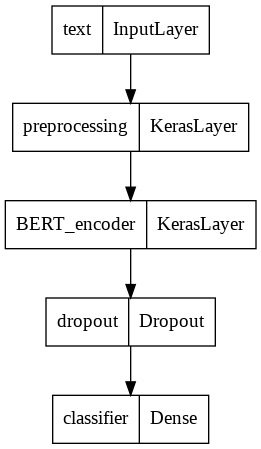

In [24]:
# plotting the model (requires pydot and graphviz)
tf.keras.utils.plot_model(bug_assignee_classifier)

In [25]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_train_steps = steps_per_epoch * epochs

# Here we are using AdamW with a linear learning rate schedule.
# Because of the rolling averages in the optimization logic we need a few warm up steps.
warmup_ratio = 0.1
num_warmup_steps = int(warmup_ratio*num_train_steps)
init_lr = 1e-3

optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.CategoricalAccuracy()

# compiling the model
bug_assignee_classifier.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)


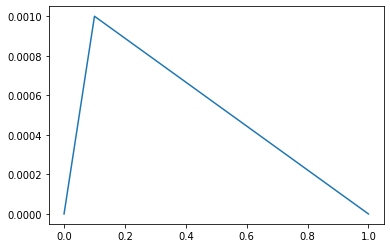

In [26]:
# visualizing our learning rate schedule
x = np.array([0,warmup_ratio,1])
y = np.array([0, init_lr,0])
plt.plot(x,y)

In [27]:
print(f'Training model with {tfhub_handle_encoder}')
history = bug_assignee_classifier.fit(x=train_dataset,
                               validation_data=val_dataset,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/15
94/94 [==============================] - 24s 206ms/step - loss: 3.5847 - categorical_accuracy: 0.0698 - val_loss: 3.3127 - val_categorical_accuracy: 0.1187
Epoch 2/15
94/94 [==============================] - 18s 195ms/step - loss: 3.2301 - categorical_accuracy: 0.1307 - val_loss: 2.8848 - val_categorical_accuracy: 0.2313
Epoch 3/15
94/94 [==============================] - 19s 198ms/step - loss: 2.8546 - categorical_accuracy: 0.2061 - val_loss: 2.4421 - val_categorical_accuracy: 0.2953
Epoch 4/15
94/94 [==============================] - 19s 196ms/step - loss: 2.4139 - categorical_accuracy: 0.3205 - val_loss: 1.8900 - val_categorical_accuracy: 0.4484
Epoch 5/15
94/94 [==============================] - 19s 198ms/step - loss: 1.9809 - categorical_accuracy: 0.4362 - val_loss: 1.3201 - val_categorical_accuracy: 0.6641
Epoch 6/15
94/94 [==============================] - 18s 195ms/step - loss

In [28]:
loss, accuracy = bug_assignee_classifier.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

20/20 [==============================] - 3s 140ms/step - loss: 0.0355 - categorical_accuracy: 0.9969
Loss: 0.0355026051402092
Accuracy: 0.996874988079071


dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


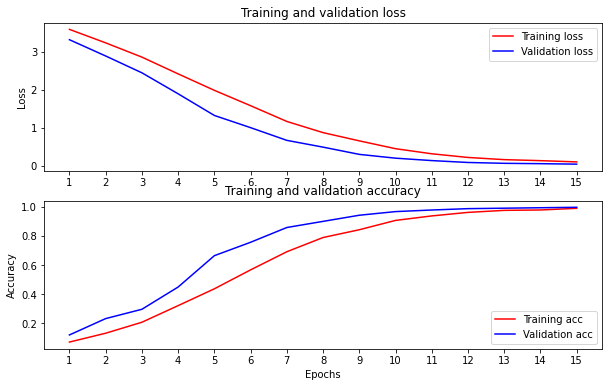

In [29]:
# plotting accuracy and loss history

history_dict = history.history
print(history_dict.keys())

acc = history_dict['categorical_accuracy']
val_acc = history_dict['val_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
#fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
#plt.xlabel('Epochs')
plt.xticks(epochs)
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xticks(epochs)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right');

Save Bert Model

In [30]:
# saving 

saved_model_path = save_path + "bug_assignee_prediction_bert_model"
bug_assignee_classifier.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/bug_assignee_prediction_bert_model/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/bug_assignee_prediction_bert_model/assets


RNN

In [31]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [32]:
vocab = np.array(encoder.get_vocabulary())
vocab

array(['', '[UNK]', 'the', ..., 'disappeared', 'dirname', 'differentiate'],
      dtype='<U4531')

In [33]:
rnn_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(assignee_dict))
])

In [34]:
print(rnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, None, 64)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [35]:
rnn_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])

In [36]:
history = rnn_model.fit(train_dataset, epochs=20,
                    validation_data=val_dataset)

Epoch 1/20
94/94 [==============================] - 58s 416ms/step - loss: 3.4512 - accuracy: 0.0811 - val_loss: 3.3648 - val_accuracy: 0.0938
Epoch 2/20
94/94 [==============================] - 36s 377ms/step - loss: 3.3321 - accuracy: 0.0984 - val_loss: 3.1273 - val_accuracy: 0.1359
Epoch 3/20
94/94 [==============================] - 36s 377ms/step - loss: 3.1254 - accuracy: 0.1187 - val_loss: 2.9759 - val_accuracy: 0.1172
Epoch 4/20
94/94 [==============================] - 37s 396ms/step - loss: 2.9198 - accuracy: 0.1626 - val_loss: 2.7485 - val_accuracy: 0.1953
Epoch 5/20
94/94 [==============================] - 37s 390ms/step - loss: 2.6946 - accuracy: 0.2234 - val_loss: 2.5086 - val_accuracy: 0.2750
Epoch 6/20
94/94 [==============================] - 39s 413ms/step - loss: 2.4281 - accuracy: 0.2886 - val_loss: 2.1324 - val_accuracy: 0.3766
Epoch 7/20
94/94 [==============================] - 36s 386ms/step - loss: 2.1806 - accuracy: 0.3587 - val_loss: 2.0112 - val_accuracy: 0.4328